### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import antropy as ant
import spkit as sp
import seaborn as sns
sns.set()
import EntropyHub as En
from sklearn.preprocessing import MinMaxScaler

import warnings
from vmdpy import VMD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV


### Read and preprocess data

In [2]:
EEG_72_CH2 = pd.read_csv('EEG_72_CH2.csv')
bis_72 = pd.read_csv('bis_72.csv')
B72=bis_72['BIS/BIS']
E72=EEG_72_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 72 is {} and {} '.format(E72.shape,B72.shape) )

The shape of EEG signals and BIS for patient 72 is (1066508,) and (8329,) 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E72)

Missing Values:
Total Missing Values: 380
Percentage of Missing Values: 0.03563030000712606 %


In [4]:
E72_copy = np.copy(E72)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
handle_missing_values(E72_copy)

array([2.55, 2.55, 2.55, ..., 1.85, 1.85, 1.85])

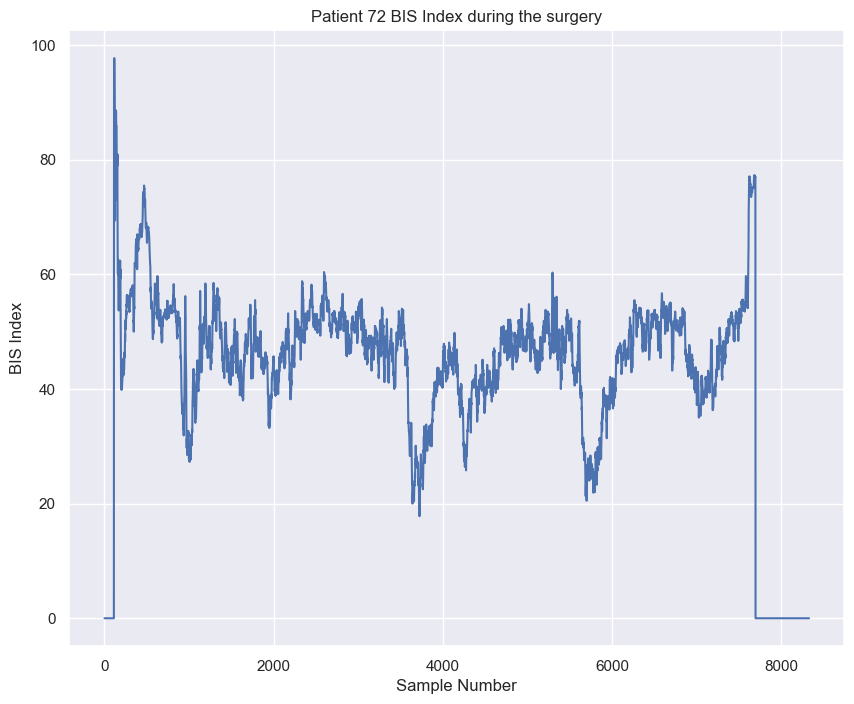

In [6]:
# Patient 92 BIS values throughout the surgery
fig = plt.figure(figsize=(10, 8))
plt.plot(B72)
plt.xlabel("Sample Number")
plt.ylabel("BIS Index")
plt.title("Patient 72 BIS Index during the surgery")
plt.show()

### Selecting EEG signals

In [7]:

# Assuming BIS and EEG are numpy arrays
BIS = B72
EEG = E72_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 120
bis_end_index = 7690

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print('length of selected bis is', len(selected_bis))
print(selected_EEG)

length of selected bis is 7570
[-45.1 -42.4 -38.4 ...   2.6  18.8  26.2]


In [8]:
#bandpass filter

# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the frequency bands
low = 0.01
high = 63.5
fs=128

# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply bandpass filters to the EEG signal
  
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs)



# Plot the original and filtered signals
time = np.arange(len(eeg_signal)) / fs

Number of BIS before windowing: 7570


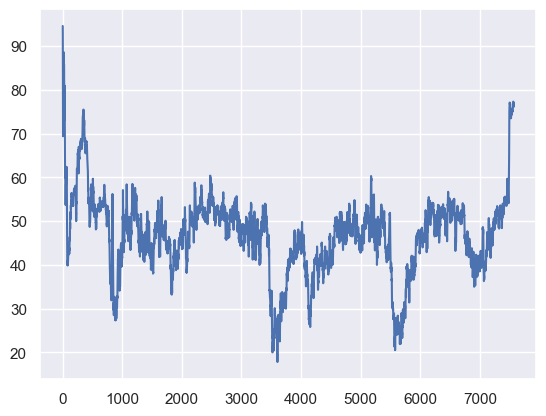

In [9]:
# Replacing the zero values in BIS
from scipy.interpolate import interp1d

def replace_zeroes_with_interpolation(series):
    # Find indices and values of non-zero elements
    non_zero_indices = [i for i, val in enumerate(series) if val != 0]
    non_zero_values = [series[i] for i in non_zero_indices]

    # Create an interpolation function using scipy's interp1d
    interpolation_function = interp1d(non_zero_indices, non_zero_values, kind='linear', bounds_error=False, fill_value="extrapolate")

    # Replace zeroes with interpolated values
    new_series = [interpolation_function(i) if val == 0 else val for i, val in enumerate(series)]

    return new_series

# Test the function
series = selected_bis
new_bis = replace_zeroes_with_interpolation(series)
plt.plot(new_bis)
print("Number of BIS before windowing:", len(new_bis))

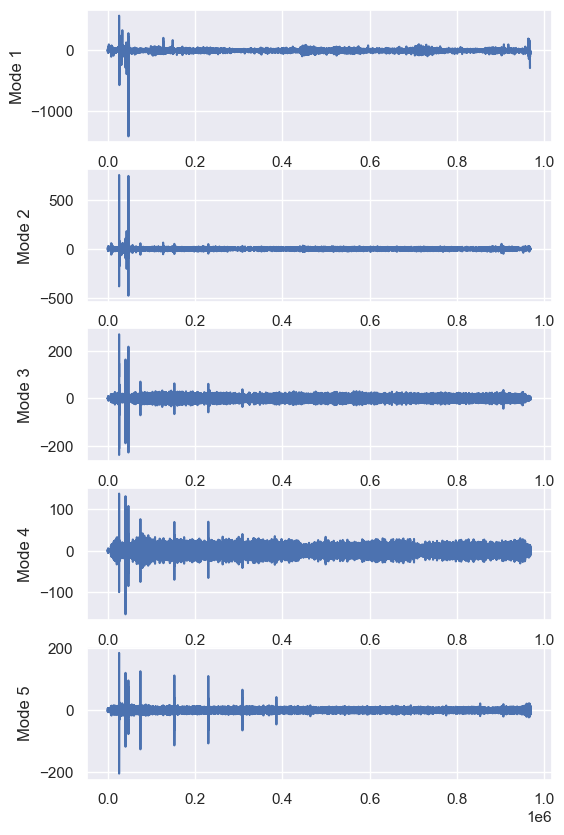

In [10]:

signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes

fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

### Save the modes in csv

In [12]:
np.savetxt("modes0.csv", modes[0], delimiter=",", header="modes0")
np.savetxt("modes1.csv", modes[1], delimiter=",", header="modes1")
np.savetxt("modes2.csv", modes[2], delimiter=",", header="modes2")
np.savetxt("modes3.csv", modes[3], delimiter=",", header="modes3")
np.savetxt("modes4.csv", modes[4], delimiter=",", header="modes4")

In [76]:
data0=pd.read_csv('modes0.csv')
data1=pd.read_csv('modes1.csv')
data2=pd.read_csv('modes2.csv')
data3=pd.read_csv('modes3.csv')
data4=pd.read_csv('modes4.csv')
data0

# modes0
0        6.651456
1        6.753310
2        6.880098
3        6.687745
4        6.466986
...           ...
968955 -46.303744
968956 -46.092216
968957 -46.148032
968958 -45.769769
968959 -45.720598

[968960 rows x 1 columns]

Number of BIS: 7515


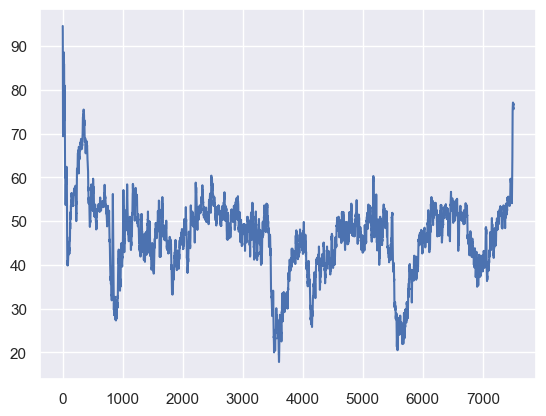

In [11]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = new_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [12]:
#### For entropies

def moving_sliding_window(data, method, window_size_sec=56, overlap_sec=55, sampling_rate=128):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            embedding_dimension = 2
            tolerance = 0.2
            sample_entropy = sampen(window, emb_dim=embedding_dimension, tolerance=tolerance)
            result.append(sample_entropy)
    
            
        if method == "spectral entropy":
            # Calculate sample entropy within the window
            sf=128
            spectral_entropy = ant.spectral_entropy(window, sf)
            result.append(spectral_entropy)
            
            
        if method == "lzc":
            # Calculate sample entropy within the window
            lzc_entropy = ant.lziv_complexity(window)
            result.append(lzc_entropy)
            
        if method == "svd":
            # Calculate sample entropy within the window
            svd_entropy = ant.svd_entropy(window)
            result.append(svd_entropy)
            
        if method == "dispm":
            # Calculate dispersion_entropy_multiscale_refined within the window
            disp_m, prob = sp.dispersion_entropy_multiscale_refined(window,classes=2, emb_dim=3, delay=1,return_all=False)
            result.append(disp_m)

        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            #Dispersion_entropy, prob =En.DispEn(window,classes=2, scale=3, emb_dim=8, delay=2,return_all=False)
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=2, scale=4, emb_dim=3, delay=1,return_all=False)
            result.append(Dispersion_entropy)
            
        if method == "fuzzy":
            # Calculate sample entropy within the window
            Fuzzy_entropy, prob =En.FuzzEn(window, m=3, r=0.5, Fx='gudermannian')
            #Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=5, delay=1,return_all=False)
            result.append(Fuzzy_entropy)
        
         # Detrended Fluctuation
        if method == "detf":
            detf = ant.detrended_fluctuation(window)
            result.append(detf)
            
             # Petrosian
        if method == "pet":
            pet = ant.petrosian_fd(window)
            result.append(pet)
            
            
             # hjorth-mobility
        if method == "hm":
            hm = ant.hjorth_params(window)[0]
            result.append(hm)
            
             # hjorth-complex
        if method == "hc":
            hc = ant.hjorth_params(window)[1]
            result.append(hc)
            
            # Higuchi Fractal Dimension
        if method == "hfd":
            hfd = ant.higuchi_fd(window)
            result.append(hfd)
          
            # # Katz Fractal Dimension
        if method == "kfd":
            kfd = ant.katz_fd(window)
            result.append(kfd)
            
    
        
    return result


In [13]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 7515


Number of features: 7515


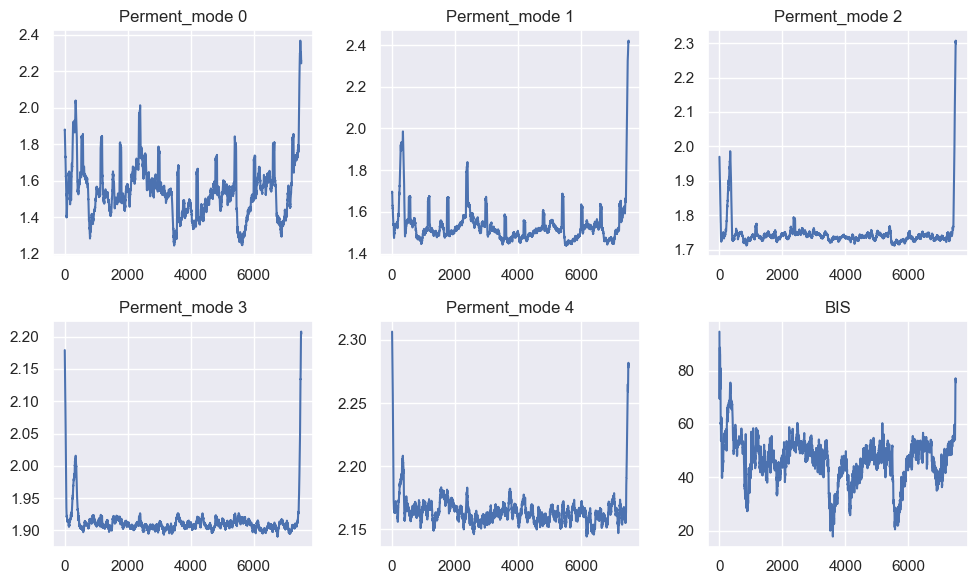

In [14]:
print(f"Number of features:", len(resultsp_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsp_0)
axes[0, 0].set_title('Perment_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsp_1)
axes[0, 1].set_title('Perment_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsp_2)
axes[0, 2].set_title('Perment_mode 2')

axes[1, 0].plot(resultsp_3)
axes[1, 0].set_title('Perment_mode 3')

axes[1, 1].plot(resultsp_4)
axes[1, 1].set_title('Perment_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()



In [15]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultspet_0 = moving_sliding_window(data0, method='pet')
resultspet_1 = moving_sliding_window(data1, method='pet')
resultspet_2 = moving_sliding_window(data2, method='pet')
resultspet_3 = moving_sliding_window(data3, method='pet')
resultspet_4 = moving_sliding_window(data4, method='pet')
print(f"Number of features:", len(resultspet_0))

Number of features: 7515


Number of features: 7515


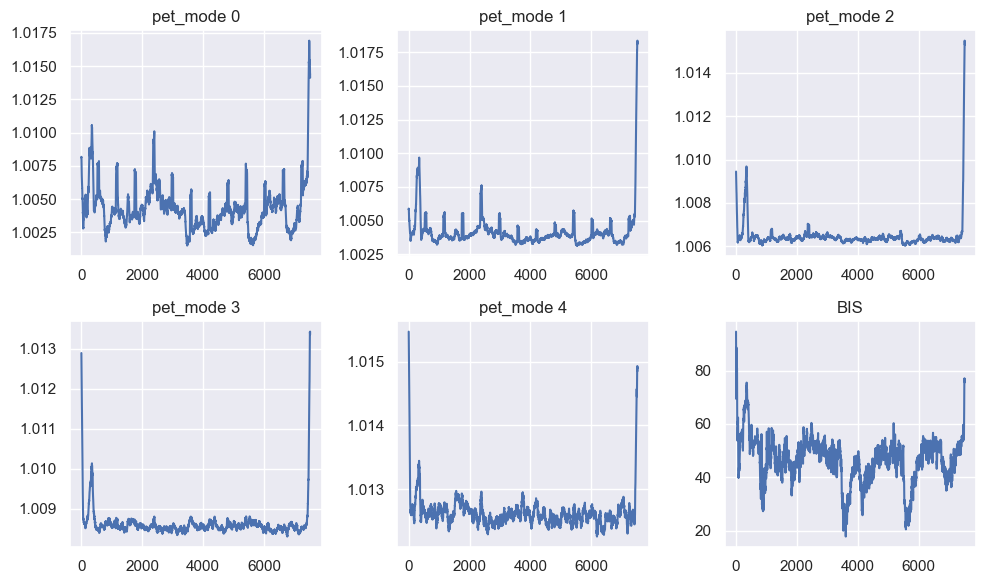

In [16]:
print(f"Number of features:", len(resultspet_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspet_0)
axes[0, 0].set_title('pet_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspet_1)
axes[0, 1].set_title('pet_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspet_2)
axes[0, 2].set_title('pet_mode 2')

axes[1, 0].plot(resultspet_3)
axes[1, 0].set_title('pet_mode 3')

axes[1, 1].plot(resultspet_4)
axes[1, 1].set_title('pet_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [17]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultshc_0 = moving_sliding_window(data0, method='hc')
resultshc_1 = moving_sliding_window(data1, method='hc')
resultshc_2 = moving_sliding_window(data2, method='hc')
resultshc_3 = moving_sliding_window(data3, method='hc')
resultshc_4 = moving_sliding_window(data4, method='hc')
print(f"Number of features:", len(resultshc_0))

Number of features: 7515


Number of features: 7515


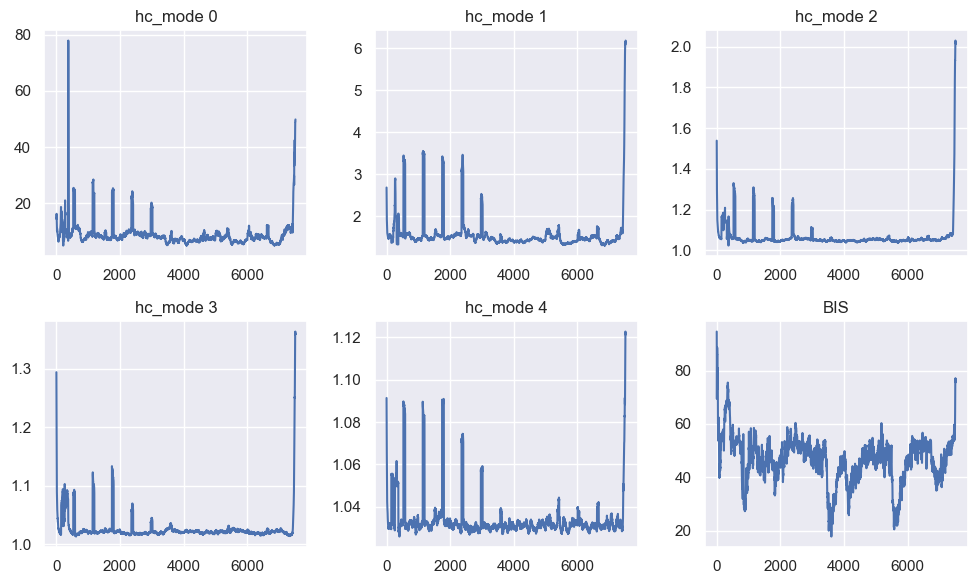

In [18]:
print(f"Number of features:", len(resultshc_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshc_0)
axes[0, 0].set_title('hc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshc_1)
axes[0, 1].set_title('hc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshc_2)
axes[0, 2].set_title('hc_mode 2')

axes[1, 0].plot(resultshc_3)
axes[1, 0].set_title('hc_mode 3')

axes[1, 1].plot(resultshc_4)
axes[1, 1].set_title('hc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [19]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultshm_0 = moving_sliding_window(data0,  method='hm')
resultshm_1 = moving_sliding_window(data1, method='hm')
resultshm_2 = moving_sliding_window(data2, method='hm')
resultshm_3 = moving_sliding_window(data3, method='hm')
resultshm_4 = moving_sliding_window(data4, method='hm')
print(f"Number of features:", len(resultshm_0))

Number of features: 7515


Number of features: 7515


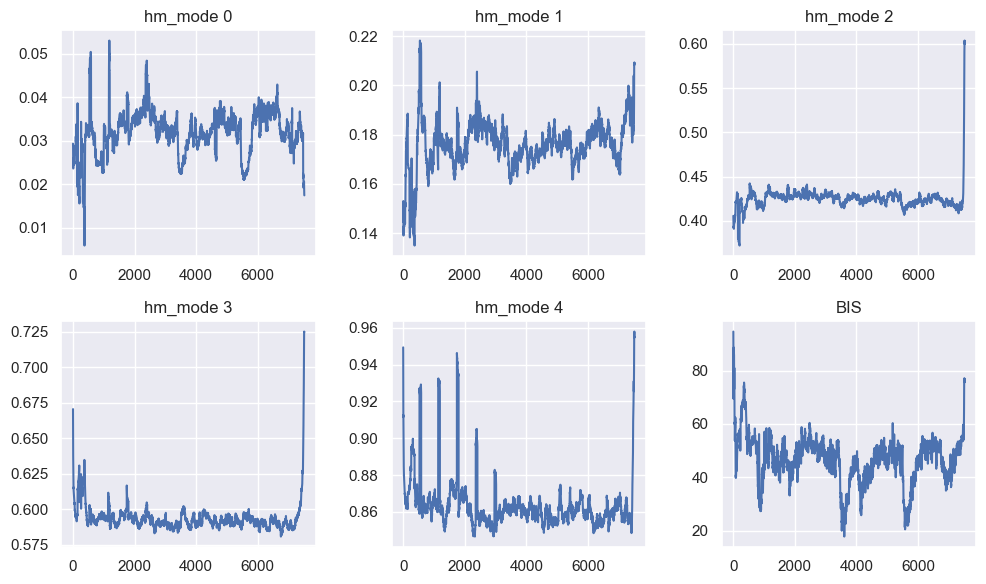

In [20]:
print(f"Number of features:", len(resultshm_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshm_0)
axes[0, 0].set_title('hm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshm_1)
axes[0, 1].set_title('hm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshm_2)
axes[0, 2].set_title('hm_mode 2')

axes[1, 0].plot(resultshm_3)
axes[1, 0].set_title('hm_mode 3')

axes[1, 1].plot(resultshm_4)
axes[1, 1].set_title('hm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [21]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultslzc_0 = moving_sliding_window(data0, method='lzc')
resultslzc_1 = moving_sliding_window(data1, method='lzc')
resultslzc_2 = moving_sliding_window(data2, method='lzc')
resultslzc_3 = moving_sliding_window(data3, method='lzc')
resultslzc_4 = moving_sliding_window(data4, method='lzc')
print(f"Number of features:", len(resultslzc_1))

Number of features: 7515


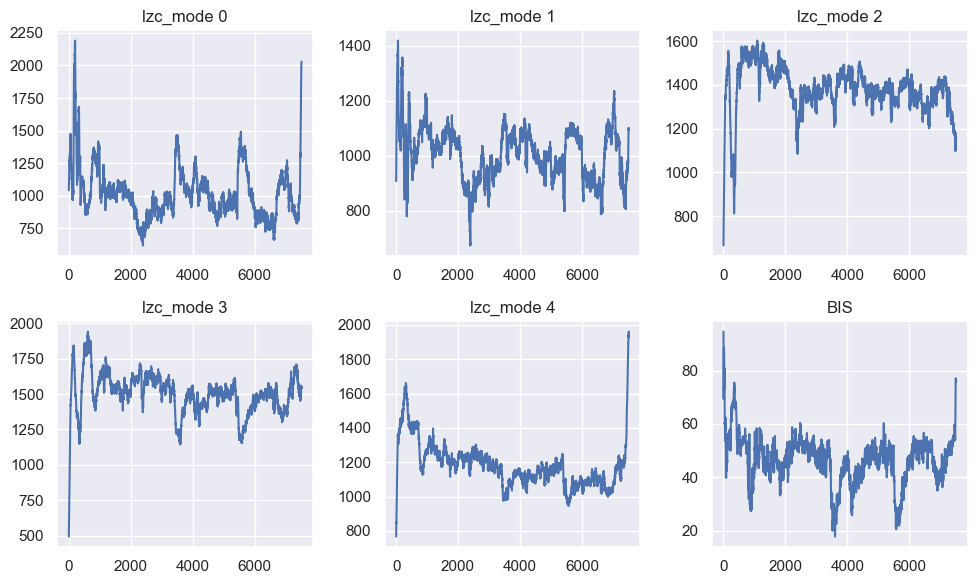

In [22]:
# Lzc


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultslzc_0)
axes[0, 0].set_title('lzc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultslzc_1)
axes[0, 1].set_title('lzc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultslzc_2)
axes[0, 2].set_title('lzc_mode 2')

axes[1, 0].plot(resultslzc_3)
axes[1, 0].set_title('lzc_mode 3')

axes[1, 1].plot(resultslzc_4)
axes[1, 1].set_title('lzc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()

ant.higuchi_fd

# Display the figure
plt.show()

In [23]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultspec_0 = moving_sliding_window(data0, method='spectral entropy')
resultspec_1 = moving_sliding_window(data1, method='spectral entropy')
resultspec_2 = moving_sliding_window(data2, method='spectral entropy')
resultspec_3 = moving_sliding_window(data3, method='spectral entropy')
resultspec_4 = moving_sliding_window(data4, method='spectral entropy')
print(f"Number of features:", len(resultspec_1))

Number of features: 7515


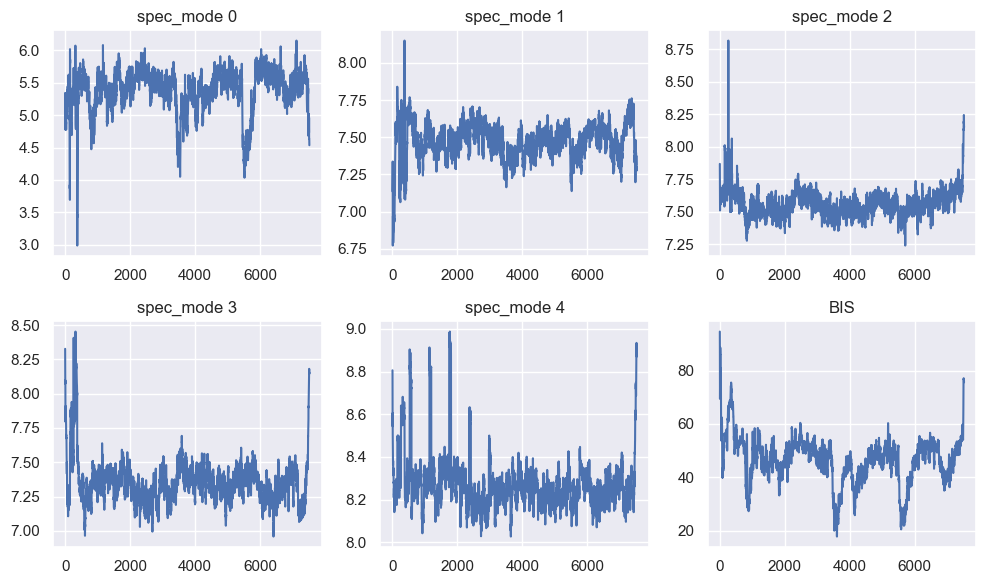

In [24]:
# spectral entropy


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspec_0)
axes[0, 0].set_title('spec_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspec_1)
axes[0, 1].set_title('spec_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspec_2)
axes[0, 2].set_title('spec_mode 2')

axes[1, 0].plot(resultspec_3)
axes[1, 0].set_title('spec_mode 3')

axes[1, 1].plot(resultspec_4)
axes[1, 1].set_title('spec_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [37]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsdispm_0 = moving_sliding_window(data0, method='dispm')
resultsdispm_1 = moving_sliding_window(data1, method='dispm')
resultsdispm_2 = moving_sliding_window(data2, method='dispm')
resultsdispm_3 = moving_sliding_window(data3, method='dispm')
resultsdispm_4 = moving_sliding_window(data4, method='dispm')
print(f"Number of features:", len(resultsdispm_1))

Number of features: 7515


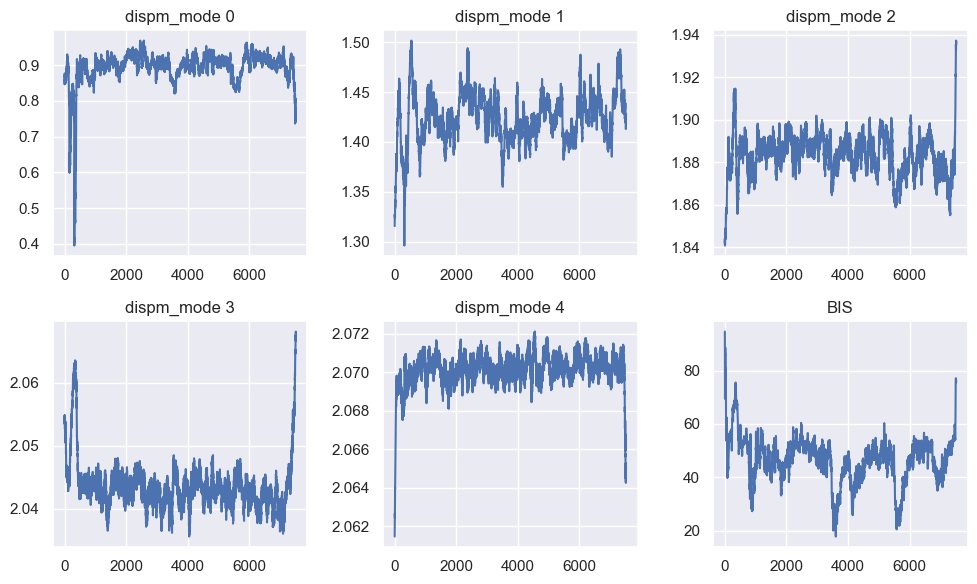

In [38]:
# dispm


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsdispm_0)
axes[0, 0].set_title('dispm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsdispm_1)
axes[0, 1].set_title('dispm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsdispm_2)
axes[0, 2].set_title('dispm_mode 2')

axes[1, 0].plot(resultsdispm_3)
axes[1, 0].set_title('dispm_mode 3')

axes[1, 1].plot(resultsdispm_4)
axes[1, 1].set_title('dispm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [39]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 7515


Number of features: 7515


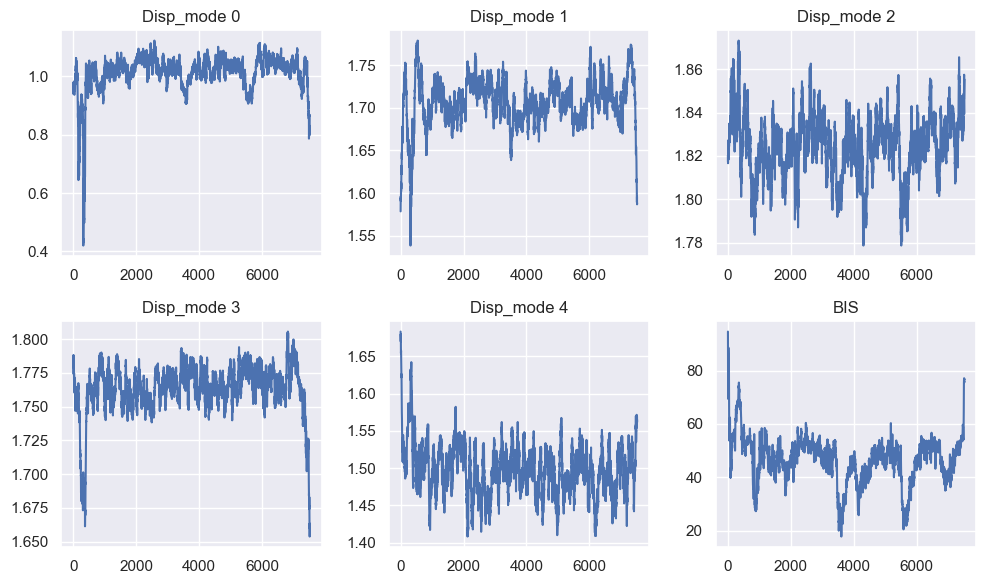

In [40]:
print(f"Number of features:", len(resultsd_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsd_0)
axes[0, 0].set_title('Disp_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsd_1)
axes[0, 1].set_title('Disp_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsd_2)
axes[0, 2].set_title('Disp_mode 2')

axes[1, 0].plot(resultsd_3)
axes[1, 0].set_title('Disp_mode 3')

axes[1, 1].plot(resultsd_4)
axes[1, 1].set_title('Disp_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [45]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultsvd_0 = moving_sliding_window(data0, method='svd')
resultsvd_1 = moving_sliding_window(data1, method='svd')
resultsvd_2 = moving_sliding_window(data2, method='svd')
resultsvd_3 = moving_sliding_window(data3, method='svd')
resultsvd_4 = moving_sliding_window(data4, method='svd')
print(f"Number of features:", len(resultsvd_1))

Number of features: 7515


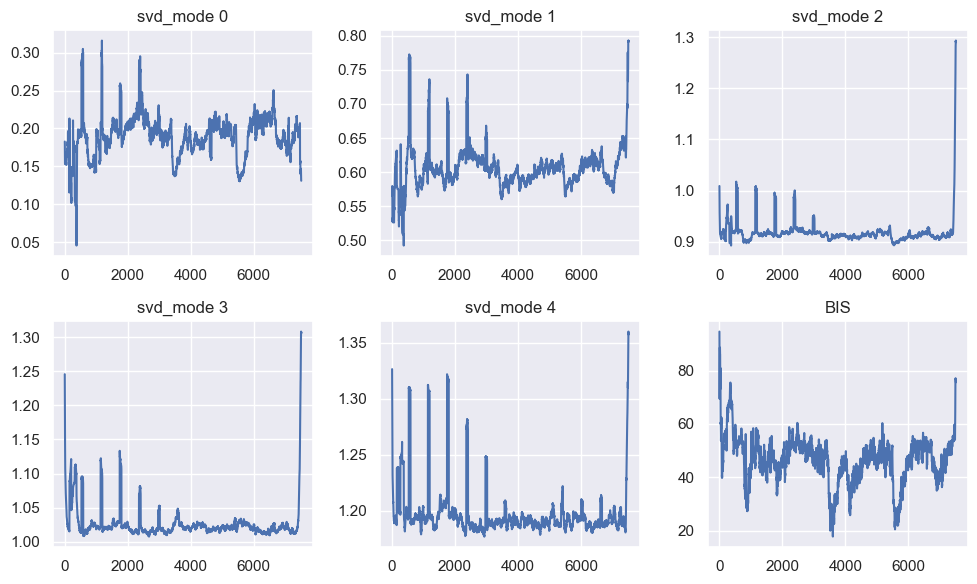

In [46]:
# svd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsvd_0)
axes[0, 0].set_title('svd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsvd_1)
axes[0, 1].set_title('svd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsvd_2)
axes[0, 2].set_title('svd_mode 2')

axes[1, 0].plot(resultsvd_3)
axes[1, 0].set_title('svd_mode 3')

axes[1, 1].plot(resultsvd_4)
axes[1, 1].set_title('svd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [47]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultshfd_0 = moving_sliding_window(data0, method='hfd')
resultshfd_1 = moving_sliding_window(data1, method='hfd')
resultshfd_2 = moving_sliding_window(data2, method='hfd')
resultshfd_3 = moving_sliding_window(data3, method='hfd')
resultshfd_4 = moving_sliding_window(data4, method='hfd')
print(f"Number of features:", len(resultshfd_0))

Number of features: 7515


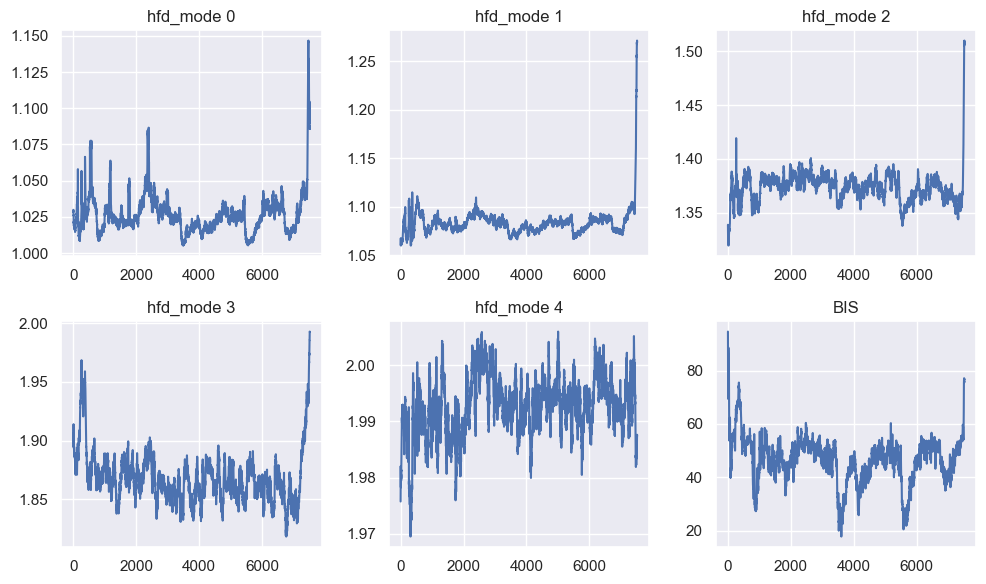

In [48]:
# hfd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshfd_0)
axes[0, 0].set_title('hfd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshfd_1)
axes[0, 1].set_title('hfd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshfd_2)
axes[0, 2].set_title('hfd_mode 2')

axes[1, 0].plot(resultshfd_3)
axes[1, 0].set_title('hfd_mode 3')

axes[1, 1].plot(resultshfd_4)
axes[1, 1].set_title('hfd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [49]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultskfd_0 = moving_sliding_window(data0, method='kfd')
resultskfd_1 = moving_sliding_window(data1, method='kfd')
resultskfd_2 = moving_sliding_window(data2, method='kfd')
resultskfd_3 = moving_sliding_window(data3, method='kfd')
resultskfd_4 = moving_sliding_window(data4, method='kfd')
print(f"Number of features:", len(resultskfd_1))

Number of features: 7515


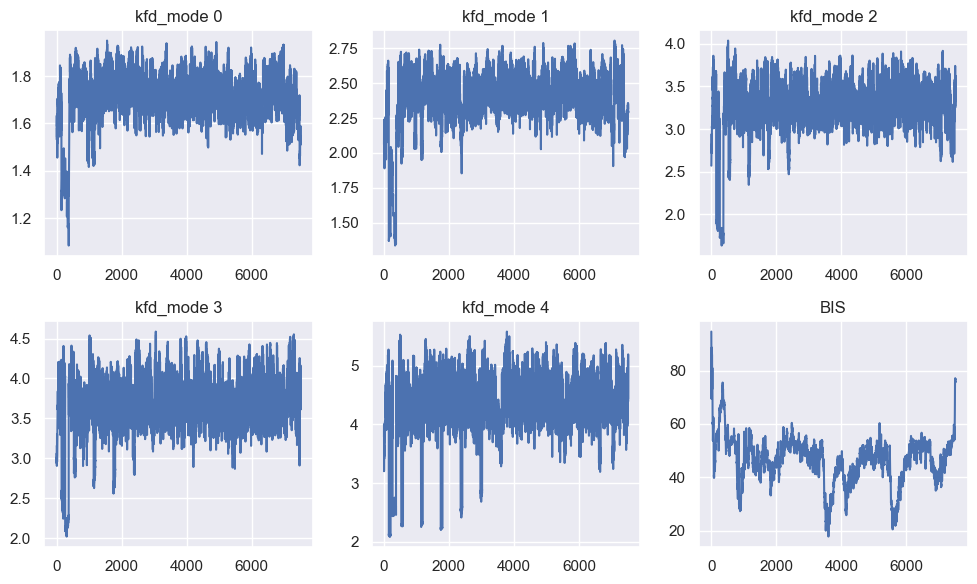

In [50]:
# kfd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultskfd_0)
axes[0, 0].set_title('kfd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultskfd_1)
axes[0, 1].set_title('kfd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultskfd_2)
axes[0, 2].set_title('kfd_mode 2')

axes[1, 0].plot(resultskfd_3)
axes[1, 0].set_title('kfd_mode 3')

axes[1, 1].plot(resultskfd_4)
axes[1, 1].set_title('kfd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [51]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultsdt_0 = moving_sliding_window(data0, method='detf')
resultsdt_1 = moving_sliding_window(data1, method='detf')
resultsdt_2 = moving_sliding_window(data2, method='detf')
resultsdt_3 = moving_sliding_window(data3, method='detf')
resultsdt_4 = moving_sliding_window(data4, method='detf')
print(f"Number of features:", len(resultsdt_0))

Number of features: 7515


Number of features: 7515


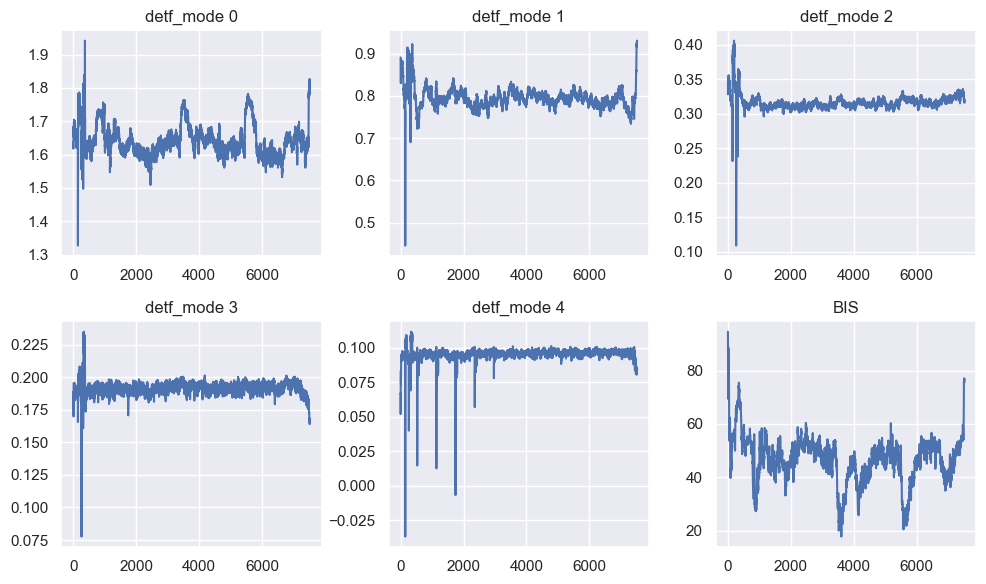

In [52]:
print(f"Number of features:", len(resultsdt_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsdt_0)
axes[0, 0].set_title('detf_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsdt_1)
axes[0, 1].set_title('detf_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsdt_2)
axes[0, 2].set_title('detf_mode 2')

axes[1, 0].plot(resultsdt_3)
axes[1, 0].set_title('detf_mode 3')

axes[1, 1].plot(resultsdt_4)
axes[1, 1].set_title('detf_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


### Create Dataframe for each feature

In [53]:
# kfd

df_kfd = pd.DataFrame({'kfd_mode0': resultskfd_0, 'kfd_mode1': resultskfd_1, 'kfd_mode2': resultskfd_2, 'kfd_mode3': resultskfd_3, 'kfd_mode4': resultskfd_4})

df_kfd['BIS']=bis_windows


In [54]:
# detf

df_detf = pd.DataFrame({'detf_mode0': resultsdt_0, 'detf_mode1': resultsdt_1, 'detf_mode2': resultsdt_2, 'detf_mode3': resultsdt_3, 'detf_mode4': resultsdt_4})

df_detf['BIS']=bis_windows
#df_detf


In [55]:
# dispm

df_dispm = pd.DataFrame({'dispm_mode0': resultsdispm_0, 'dispm_mode1': resultsdispm_1, 'dispm_mode2': resultsdispm_2, 'dispm_mode3': resultsdispm_3, 'dispm_mode4': resultsdispm_4})

df_dispm['BIS']=bis_windows
df_dispm

dispm_mode0  dispm_mode1  dispm_mode2  dispm_mode3  dispm_mode4   BIS
0        0.855321     1.315672     1.842114     2.054812     2.061456  94.6
1        0.857762     1.316755     1.844038     2.054305     2.061868  93.0
2        0.858229     1.320074     1.841283     2.053694     2.061945  88.1
3        0.846411     1.323858     1.843498     2.053990     2.062042  82.3
4        0.854944     1.327419     1.843076     2.053801     2.062130  77.5
...           ...          ...          ...          ...          ...   ...
7510     0.780788     1.414865     1.936378     2.067351     2.064940  76.6
7511     0.789061     1.418271     1.935177     2.067609     2.065043  76.0
7512     0.806402     1.418962     1.935978     2.067489     2.064302  75.7
7513     0.797887     1.418658     1.937304     2.068156     2.065141  75.6
7514     0.797909     1.420838     1.936442     2.067404     2.064928  75.8

[7515 rows x 6 columns]

In [29]:
# pet

df_pet = pd.DataFrame({'pet_mode0': resultspet_0, 'pet_mode1': resultspet_1, 'pet_mode2': resultspet_2, 'pet_mode3': resultspet_3, 'pet_mode4': resultspet_4})

df_pet['BIS']=bis_windows
#df_pet

In [30]:
# hm

df_hm = pd.DataFrame({'hm_mode0': resultshm_0, 'hm_mode1': resultshm_1, 'hm_mode2': resultshm_2, 'hm_mode3': resultshm_3, 'hm_mode4': resultshm_4})

df_hm['BIS']=bis_windows
#df_hm


In [31]:
# hc

df_hc = pd.DataFrame({'hc_mode0': resultshc_0, 'hc_mode1': resultshc_1, 'hc_mode2': resultshc_2, 'hc_mode3': resultshc_3, 'hc_mode4': resultshc_4})

df_hc['BIS']=bis_windows
#df_hc


In [32]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
#df_perm

In [43]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
#df_disp

In [33]:
# hfd

df_hfd = pd.DataFrame({'hfd_mode0': resultshfd_0, 'hfd_mode1': resultshfd_1, 'hfd_mode2': resultshfd_2, 'hfd_mode3': resultshfd_3, 'hfd_mode4': resultshfd_4})

df_hfd['BIS']=bis_windows
df_hfd

hfd_mode0  hfd_mode1  hfd_mode2  hfd_mode3  hfd_mode4   BIS
0      1.028740   1.060739   1.338796   1.904729   1.975766  94.6
1      1.028821   1.061935   1.332949   1.898419   1.977276  93.0
2      1.029201   1.063117   1.335737   1.906014   1.978379  88.1
3      1.028369   1.064103   1.333180   1.904952   1.979692  82.3
4      1.029885   1.066043   1.331277   1.903655   1.982061  77.5
...         ...        ...        ...        ...        ...   ...
7510   1.087695   1.268346   1.508989   1.988405   1.986957  76.6
7511   1.087159   1.269312   1.506290   1.987854   1.986727  76.0
7512   1.087715   1.270495   1.508907   1.992790   1.987122  75.7
7513   1.086677   1.271186   1.509827   1.992848   1.987629  75.6
7514   1.085709   1.269045   1.508704   1.992581   1.987366  75.8

[7515 rows x 6 columns]

In [34]:
# spectral entropy

df_spec = pd.DataFrame({'spec_mode0': resultspec_0, 'spec_mode1': resultspec_1, 'spec_mode2': resultspec_2, 'spec_mode3': resultspec_3, 'spec_mode4': resultspec_4})

df_spec['BIS']=bis_windows
df_spec

spec_mode0  spec_mode1  spec_mode2  spec_mode3  spec_mode4   BIS
0       5.289792    7.135723    7.868873    8.326552    8.805583  94.6
1       5.343951    7.219609    7.787403    8.161043    8.780723  93.0
2       5.218545    7.215054    7.726128    8.107463    8.629514  88.1
3       5.123147    7.218144    7.636698    8.099698    8.581375  82.3
4       5.077073    7.233128    7.637284    8.072426    8.543431  77.5
...          ...         ...         ...         ...         ...   ...
7510    4.633013    7.288026    8.235859    8.170671    8.925632  76.6
7511    4.632339    7.297638    8.231171    8.158799    8.921324  76.0
7512    4.583937    7.294233    8.212418    8.150381    8.885316  75.7
7513    4.553572    7.275613    8.148658    8.145012    8.880888  75.6
7514    4.536165    7.280762    8.161690    8.153228    8.869396  75.8

[7515 rows x 6 columns]

In [35]:
# svd

df_svd = pd.DataFrame({'svd_mode0': resultsvd_0, 'svd_mode1': resultsvd_1, 'svd_mode2': resultsvd_2, 'svd_mode3': resultsvd_3, 'svd_mode4': resultsvd_4})

df_svd['BIS']=bis_windows
df_svd

svd_mode0  svd_mode1  svd_mode2  svd_mode3  svd_mode4   BIS
0      0.182639   0.565041   1.008849   1.245883   1.326453  94.6
1      0.181328   0.571785   0.992394   1.228357   1.318399  93.0
2      0.180304   0.573181   0.982791   1.214338   1.299785  88.1
3      0.168933   0.575040   0.974699   1.210124   1.294407  82.3
4      0.170779   0.576807   0.970166   1.200798   1.288119  77.5
...         ...        ...        ...        ...        ...   ...
7510   0.132197   0.792431   1.292370   1.306244   1.359075  76.6
7511   0.132116   0.793165   1.290621   1.305546   1.359090  76.0
7512   0.131686   0.792831   1.293820   1.307318   1.357574  75.7
7513   0.131500   0.792027   1.291688   1.307033   1.357399  75.6
7514   0.130929   0.791219   1.293256   1.307147   1.357920  75.8

[7515 rows x 6 columns]

In [36]:
# lzc

df_lzc = pd.DataFrame({'lzc_mode0': resultslzc_0, 'lzc_mode1': resultslzc_1, 'lzc_mode2': resultslzc_2, 'lzc_mode3': resultslzc_3, 'lzc_mode4': resultslzc_4})

df_lzc['BIS']=bis_windows
df_lzc

lzc_mode0  lzc_mode1  lzc_mode2  lzc_mode3  lzc_mode4   BIS
0          1042        908        665        493        767  94.6
1          1055        927        698        521        785  93.0
2          1072        934        724        546        824  88.1
3          1055        919        745        548        821  82.3
4          1058        929        757        566        831  77.5
...         ...        ...        ...        ...        ...   ...
7510       1981       1093       1154       1543       1942  76.6
7511       1989       1097       1165       1550       1946  76.0
7512       1996       1101       1161       1541       1961  75.7
7513       2013       1096       1163       1548       1960  75.6
7514       2029       1095       1157       1540       1957  75.8

[7515 rows x 6 columns]

### Save the extracted data in csv

In [62]:
df_hm.to_csv('hm_72.csv', index=False)
df_hc.to_csv('hc_72.csv', index=False)
df_perm.to_csv('perm_72.csv', index=False)
df_pet.to_csv('pet_72.csv', index=False)
df_disp.to_csv('disp_72.csv', index=False)
df_dispm.to_csv('dispm_72.csv', index=False)

In [63]:
df_lzc.to_csv('lzc_72.csv' , index=False)
df_hfd.to_csv('hfd_72.csv', index=False)
df_spec.to_csv('spec_72.csv', index=False)
df_svd.to_csv('svd_72.csv', index=False)

In [64]:
df_detf.to_csv('detf_72.csv' , index=False)
df_kfd.to_csv('kfd_72.csv', index=False)

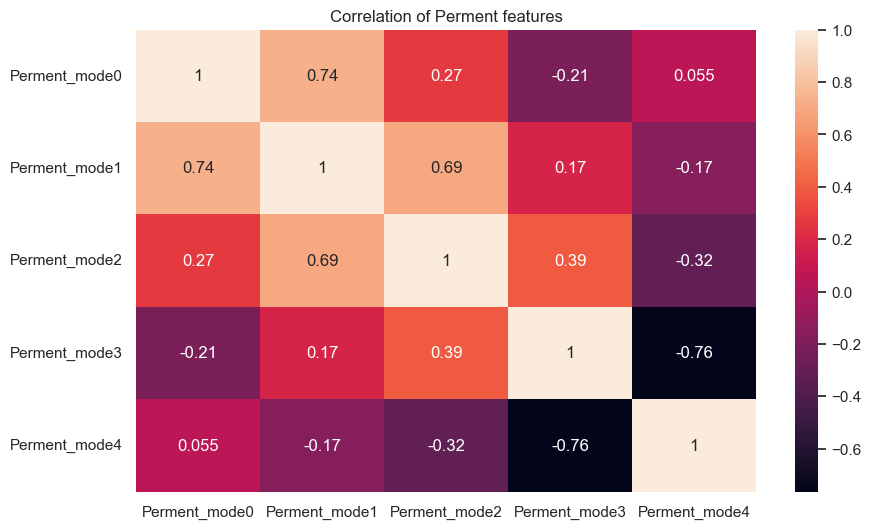

In [73]:
plt.figure(figsize=(10,6))
sns.heatmap(df_perm.corr(), annot = True)
plt.title('Correlation of Perment features')
plt.show()

### Select best features

In [82]:
data_92=pd.DataFrame({'Perment_mode4': resultsp_4,'Pet_mode3': resultspet_3, 'disp_mode4': resultsd_4, 
                  'lzc_mode2':resultslzc_2, 'spec_mode2':resultspec_2, 'hc_mode2':resultshc_2, 'hm_mode2':resultshm_2})
data_92['BIS']=bis_windows
data_92

Perment_mode4  Pet_mode3  disp_mode4  lzc_mode2  spec_mode2  hc_mode2  \
0          2.581252   1.020843    1.753173        912    8.880798  1.157700   
1          2.581324   1.020815    1.751986        902    8.894031  1.157991   
2          2.581382   1.020783    1.755460        906    8.886058  1.158254   
3          2.581440   1.020766    1.751539        906    8.896606  1.160795   
4          2.581600   1.020761    1.752087        921    8.901805  1.162138   
...             ...        ...         ...        ...         ...       ...   
4060       2.581115   1.020881    1.791967        732    9.067322  1.120550   
4061       2.581103   1.020903    1.785097        724    9.067316  1.120547   
4062       2.580895   1.020897    1.778436        719    9.067003  1.120539   
4063       2.580786   1.020908    1.775863        712    9.067279  1.120538   
4064       2.580905   1.020919    1.771321        700    9.067665  1.120536   

      hm_mode2   BIS  
0     0.554721  92.8  
1     0.555489  93.3  
2     0.556682  93.8  
3     0.556957  94.5  
4     0.557220  94.7  
...        ...   ...  
4060  0.621085  94.9  
4061  0.621083  94.9  
4062  0.621080  95.1  
4063  0.621075  95.0  
4064  0.621072  92.4  

[4065 rows x 8 columns]

In [83]:
data_92.to_csv('data_92.csv', index=False)

In [84]:
data_78

NameError: name 'data_78' is not defined

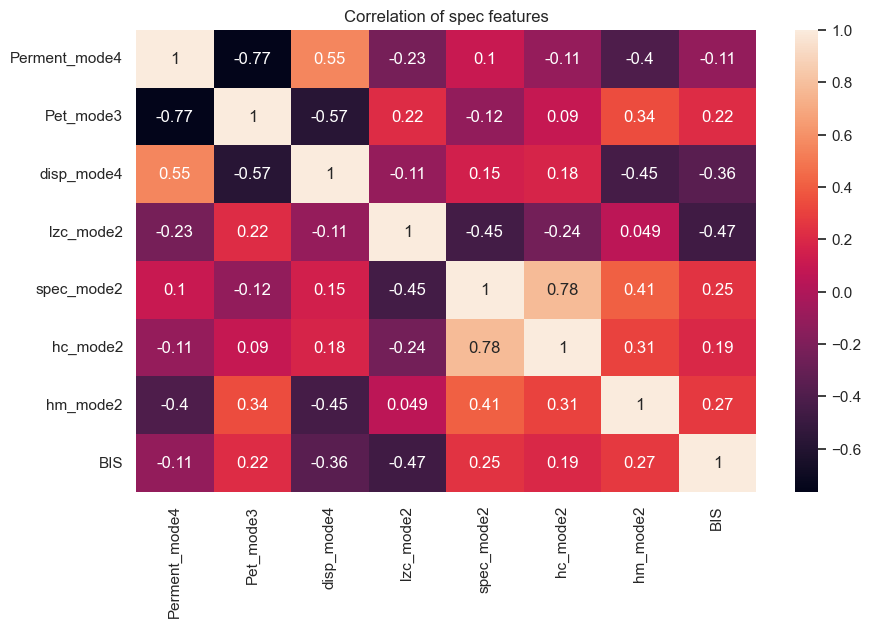

In [100]:
data_92=pd.read_csv('data_92.csv')
plt.figure(figsize=(10,6))
sns.heatmap(data_92.corr(), annot = True)
plt.title('Correlation of spec features')
plt.show()

In [101]:
metrics = {}
def plot_regression(data, column):
    
    global metrics
    
    X = data[column].values.reshape(-1, 1)
    #X = X[:, np.newaxis]
    y = data['BIS']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X_train, y_train)
    
    # Predictions
    y_predicted = reg.predict(X_test)
    
    # Show the score and r2
    #mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    
    # keep track of metrics
    
    #metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    
    # Plot the graph#
    plt.figure(figsize=(8,6))
    plt.scatter(data[column], data['BIS'], label="data", c="blue")
    plt.plot(X_test, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

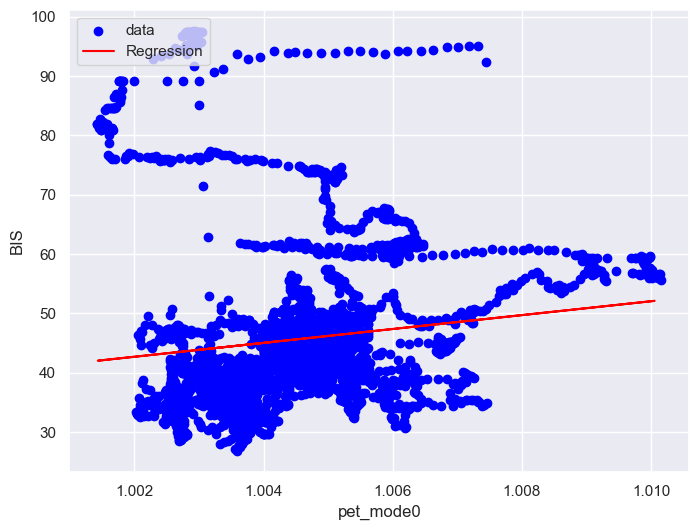

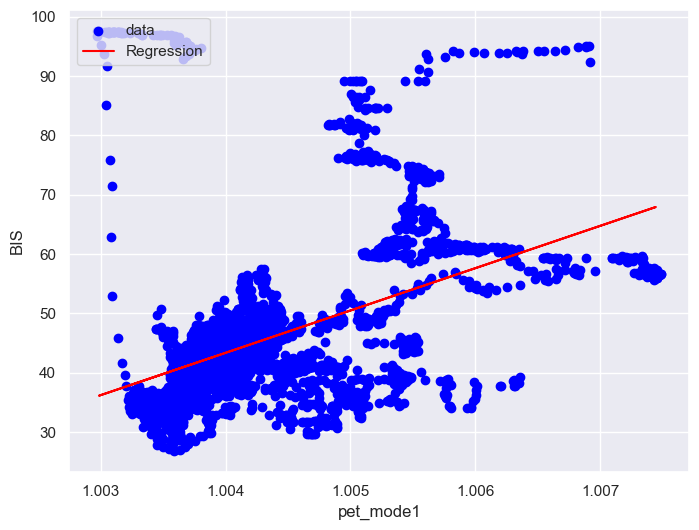

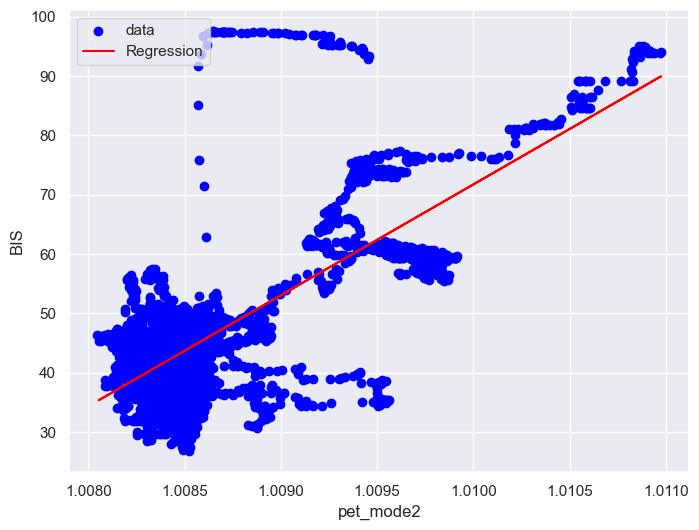

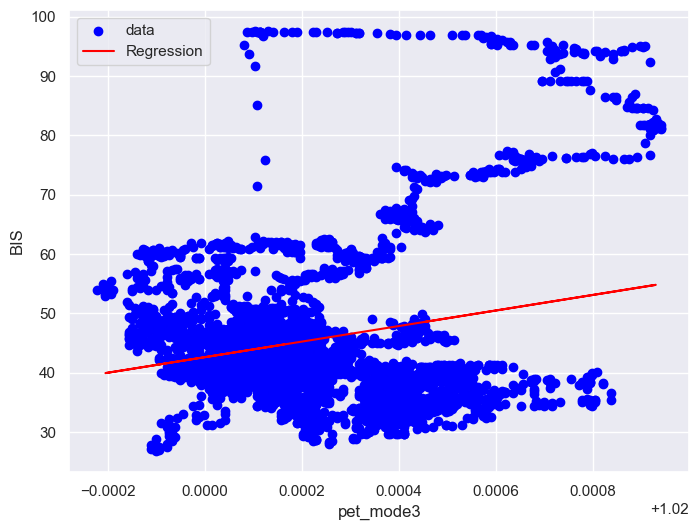

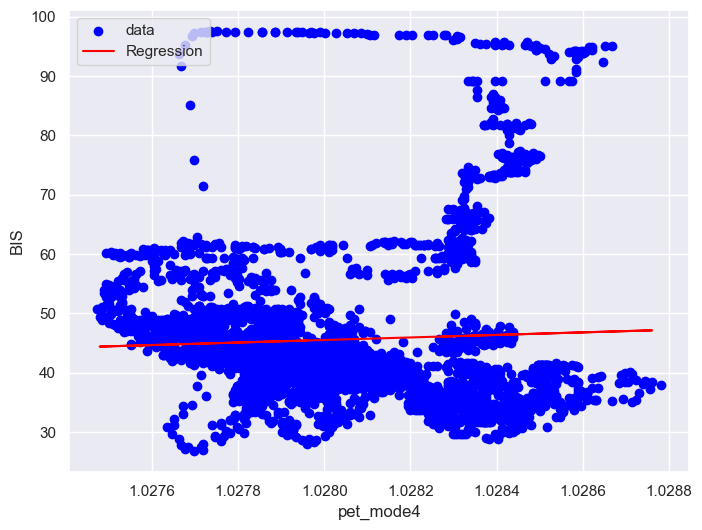

In [102]:
for column in df_pet.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_pet, column)

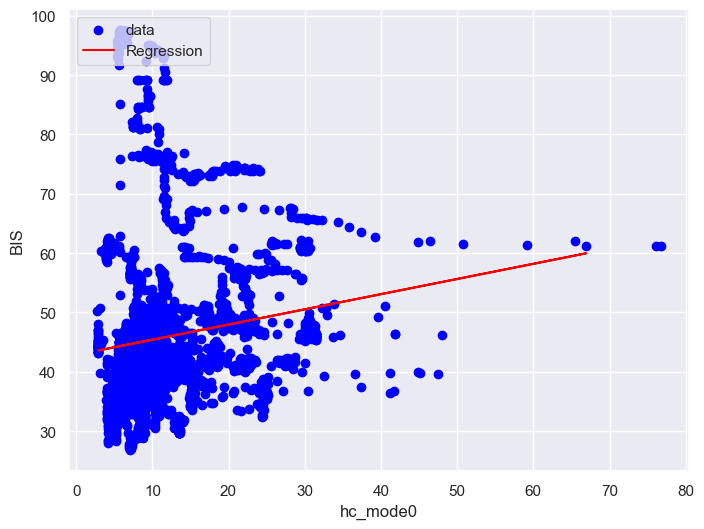

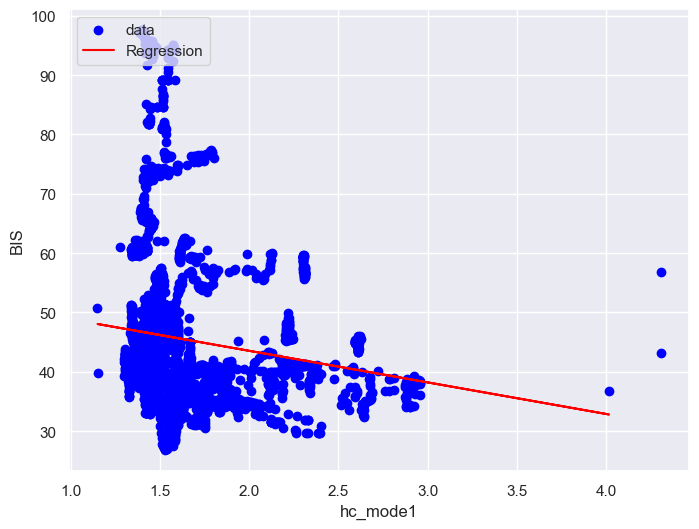

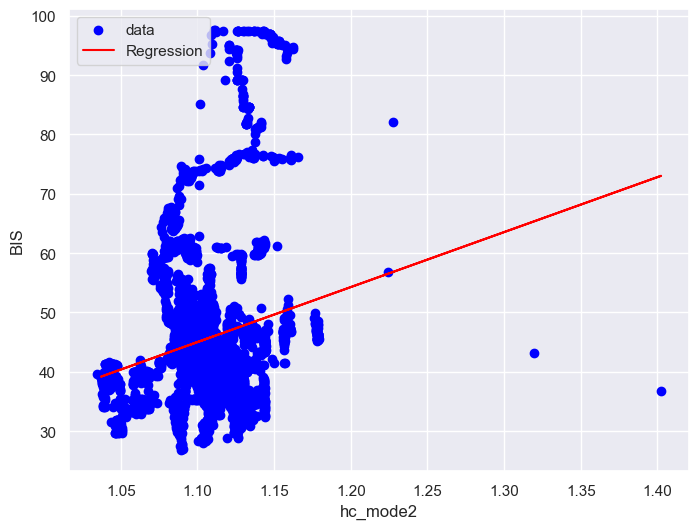

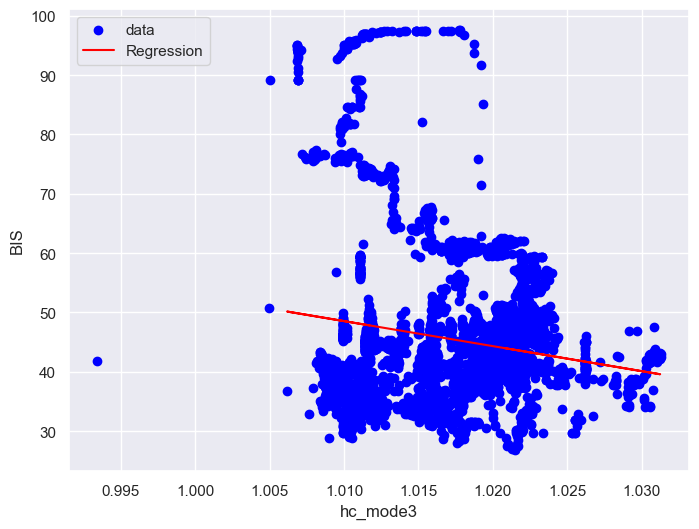

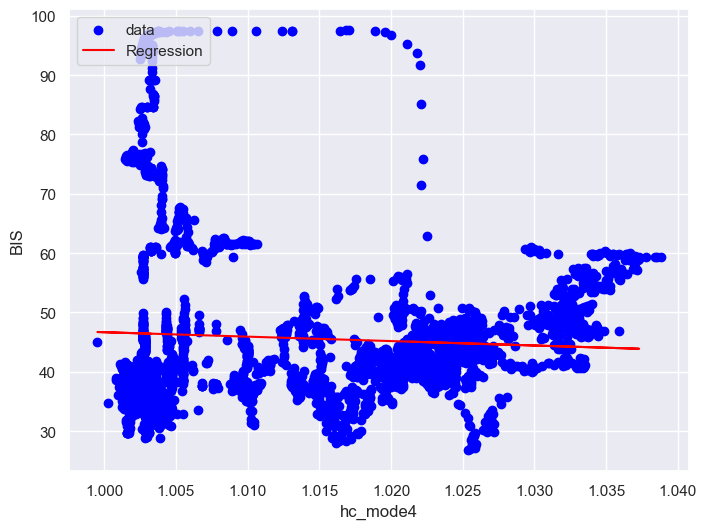

In [103]:
for column in df_hc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hc, column)

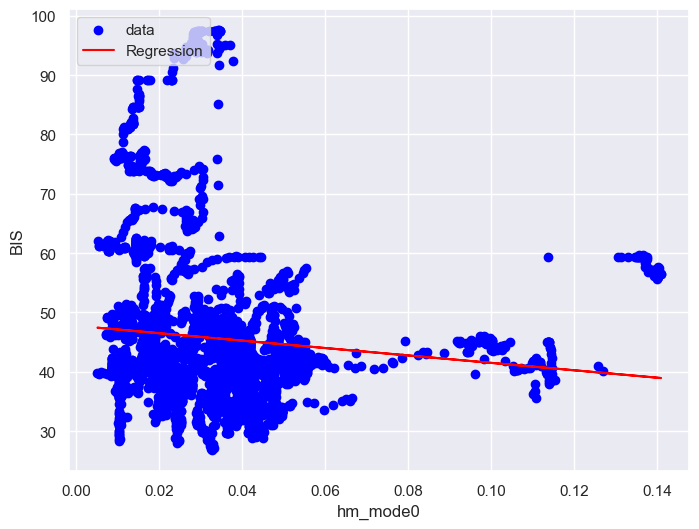

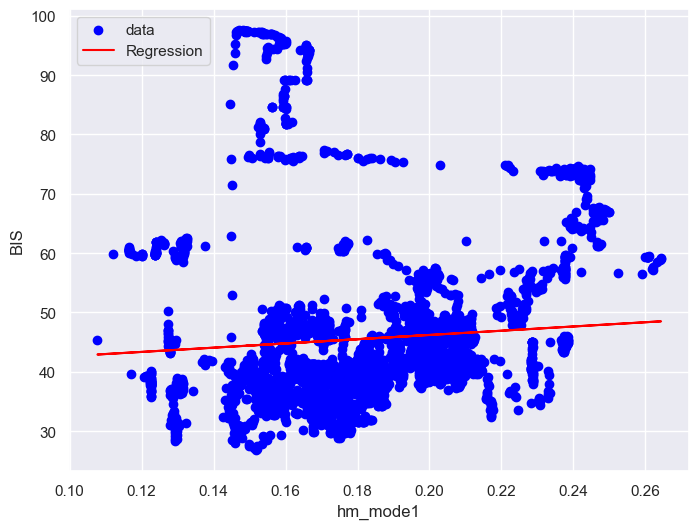

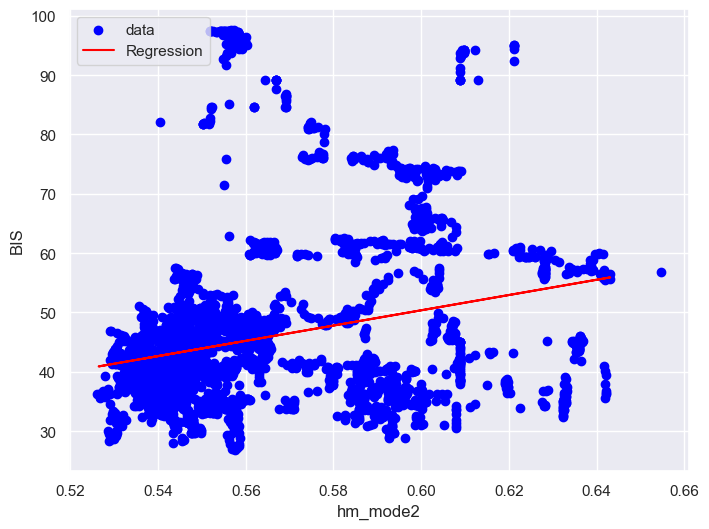

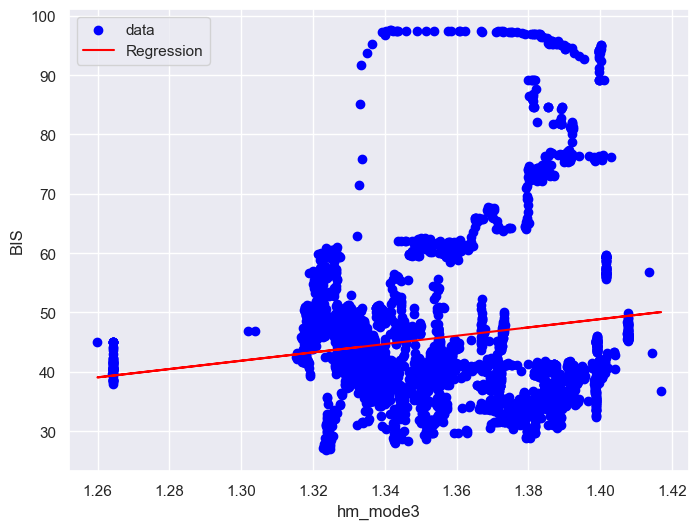

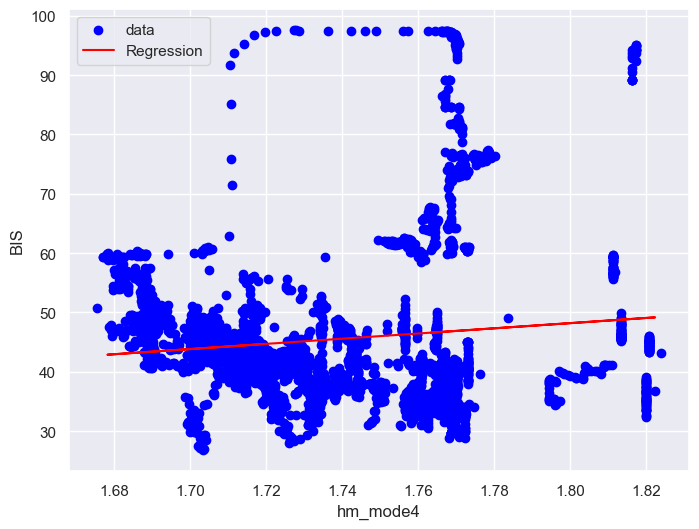

In [104]:
for column in df_hm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hm, column)

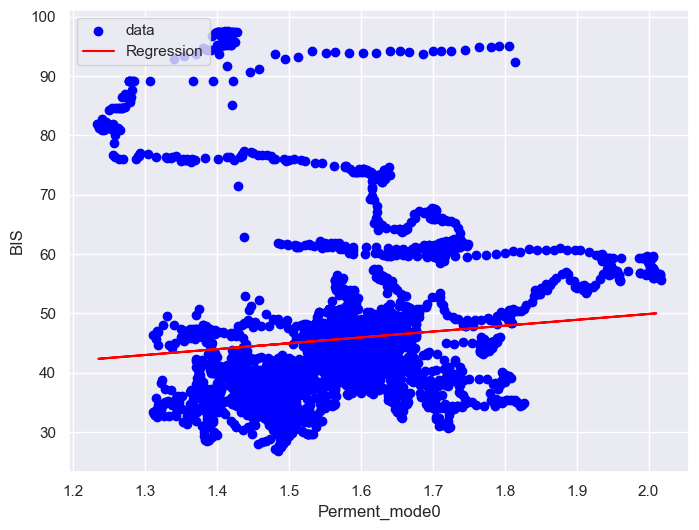

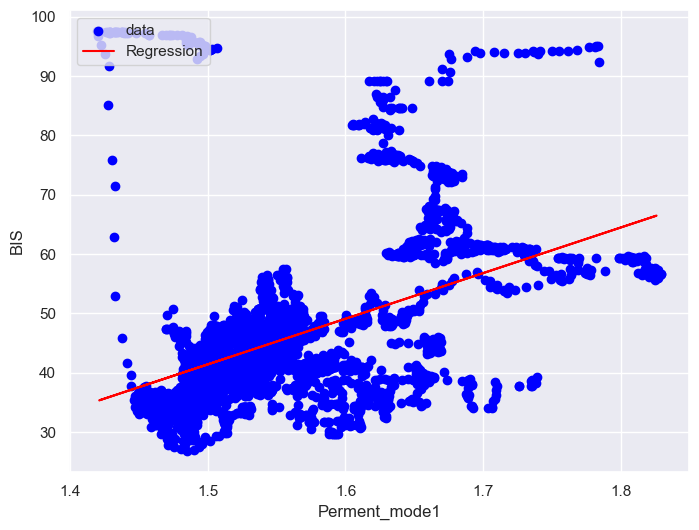

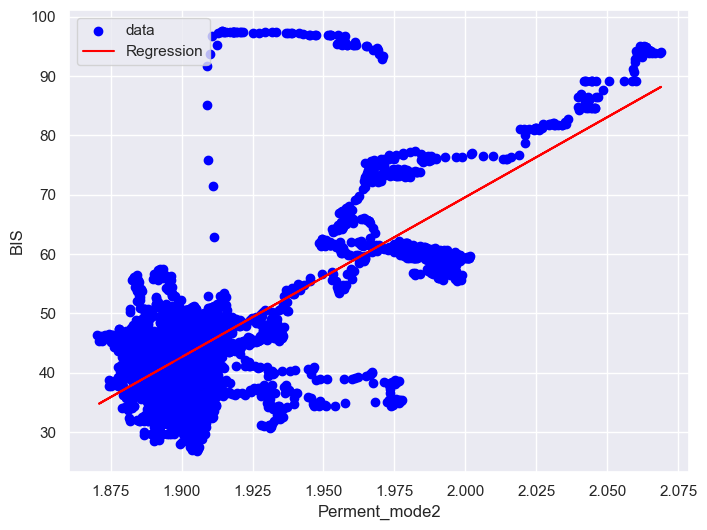

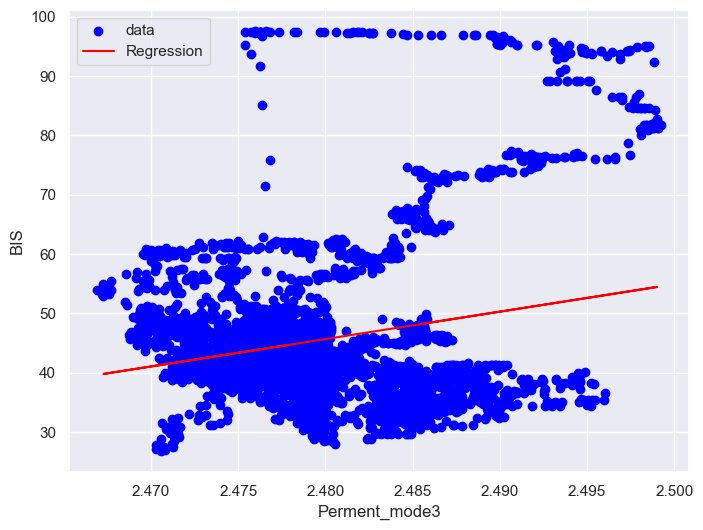

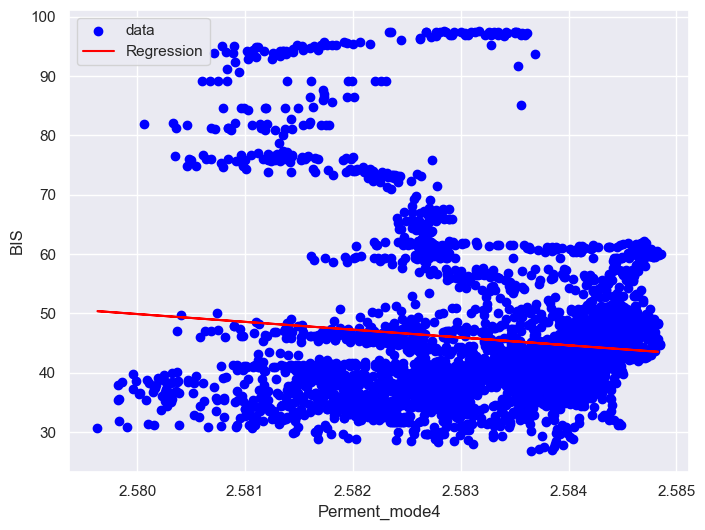

In [105]:
for column in df_perm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_perm, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

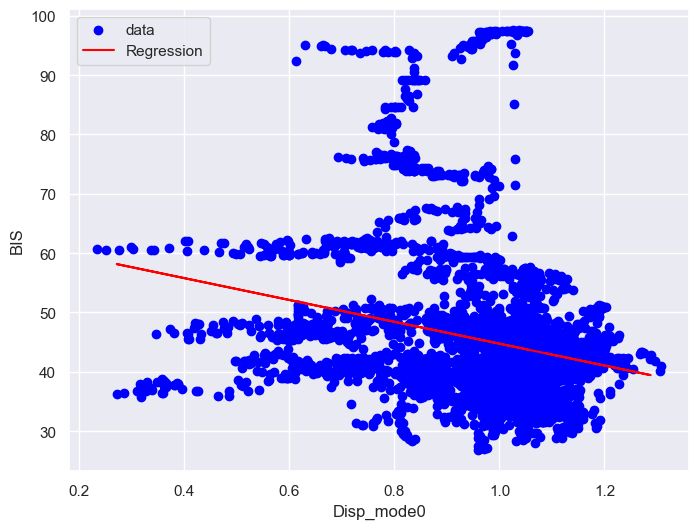

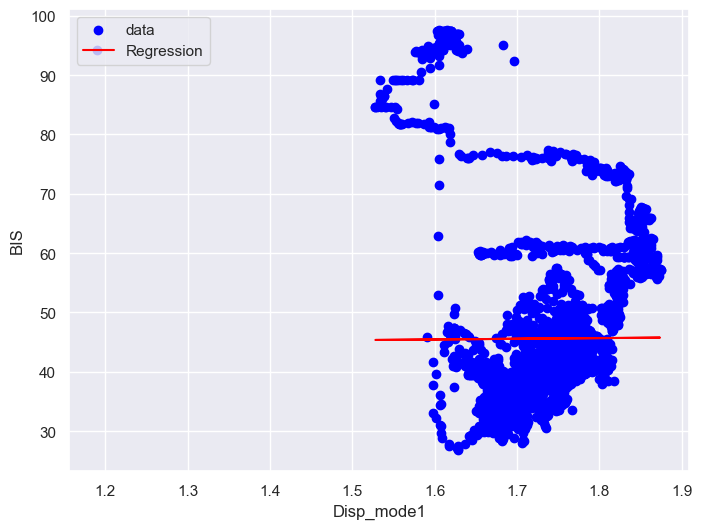

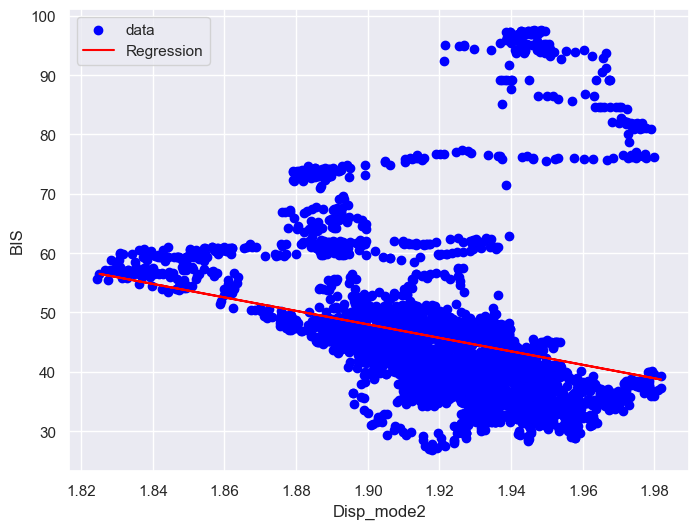

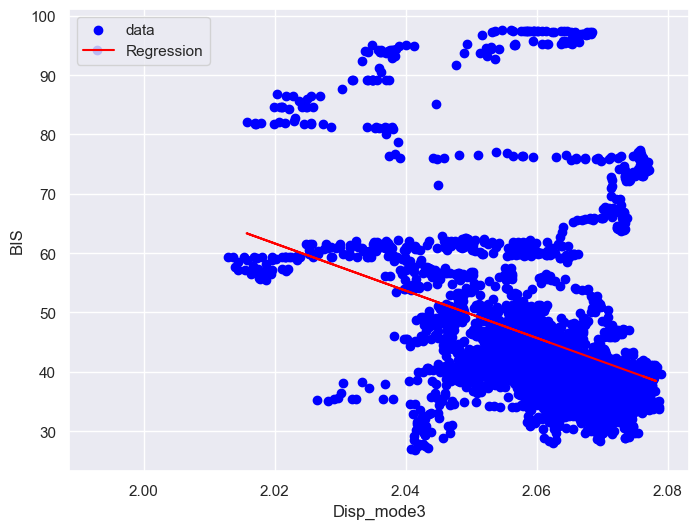

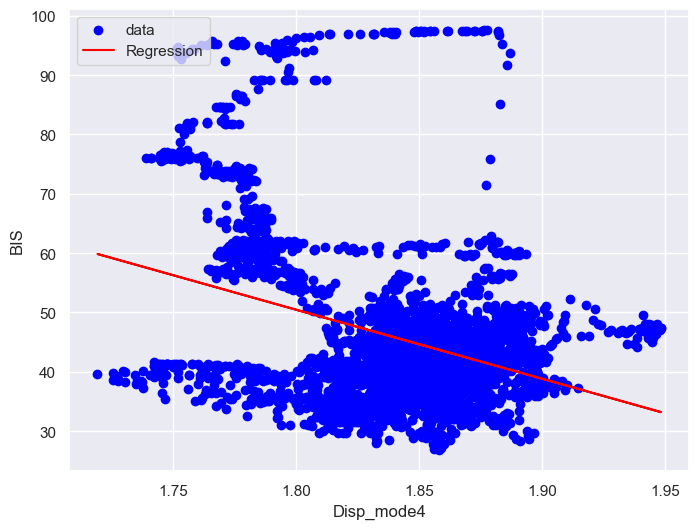

In [106]:
for column in df_disp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_disp, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

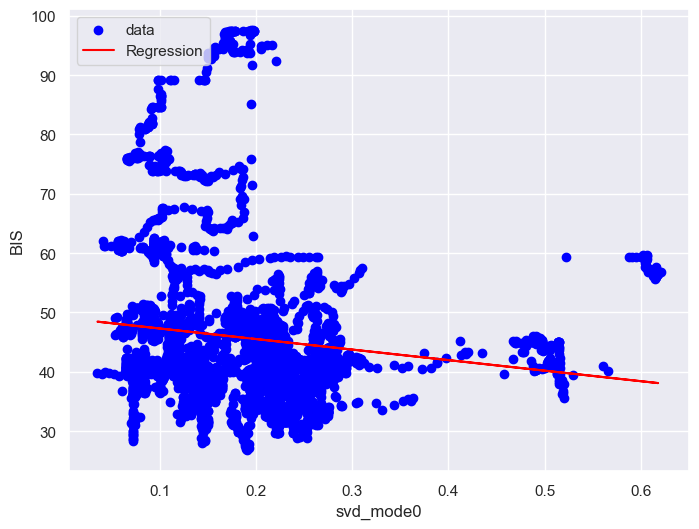

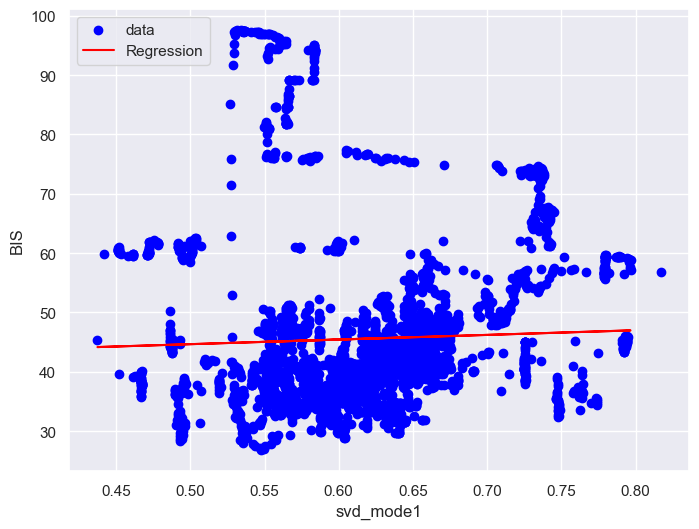

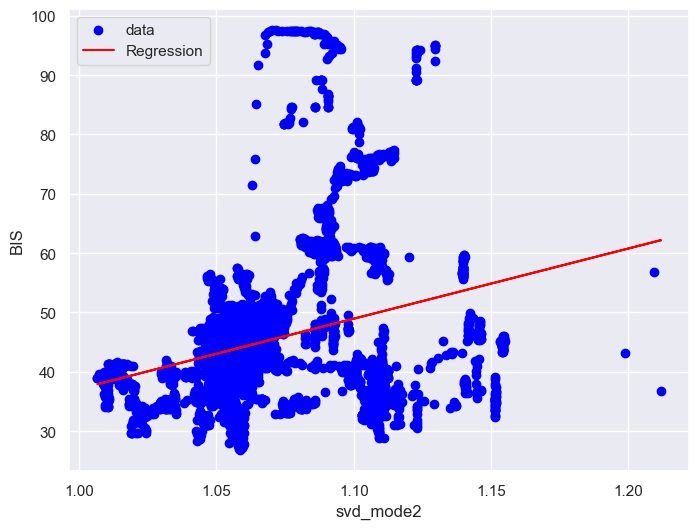

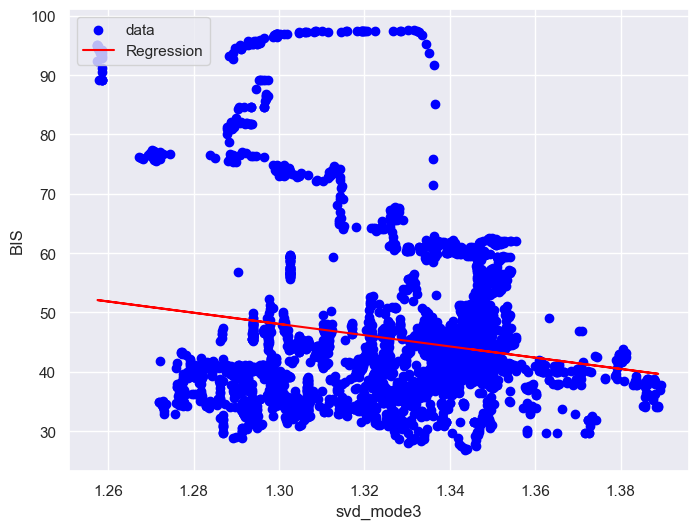

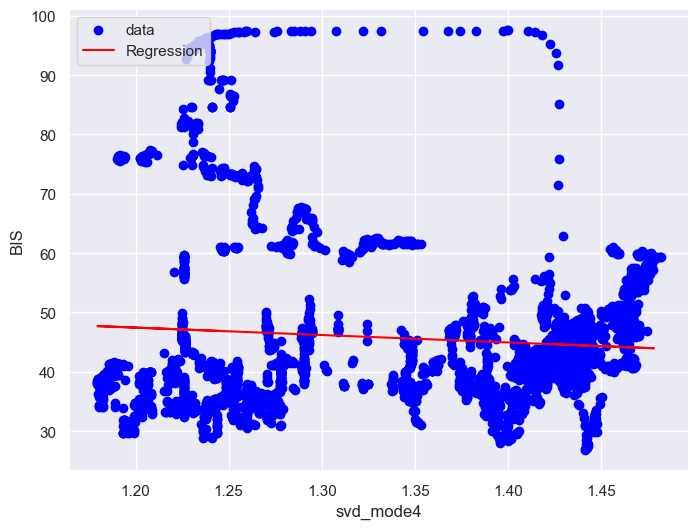

In [107]:
for column in df_svd.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_svd, column)

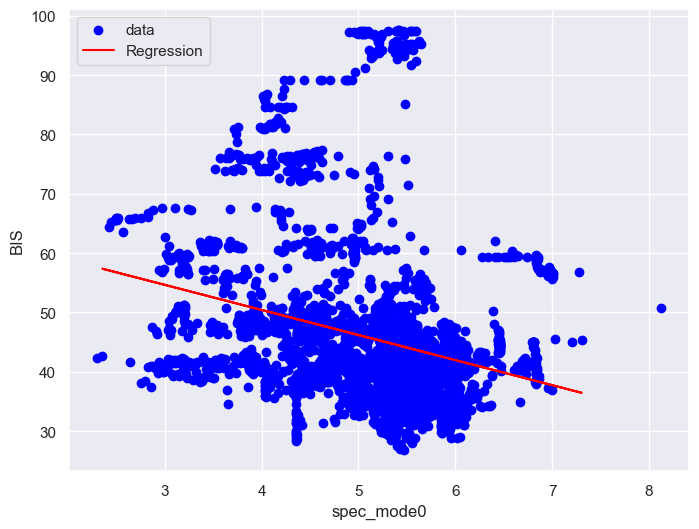

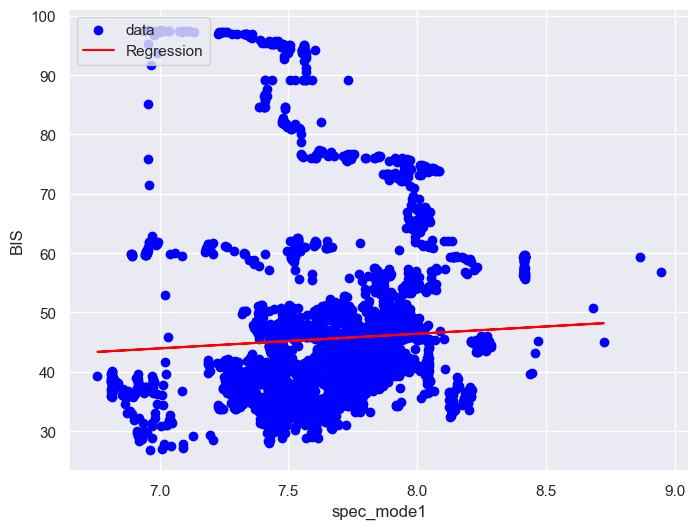

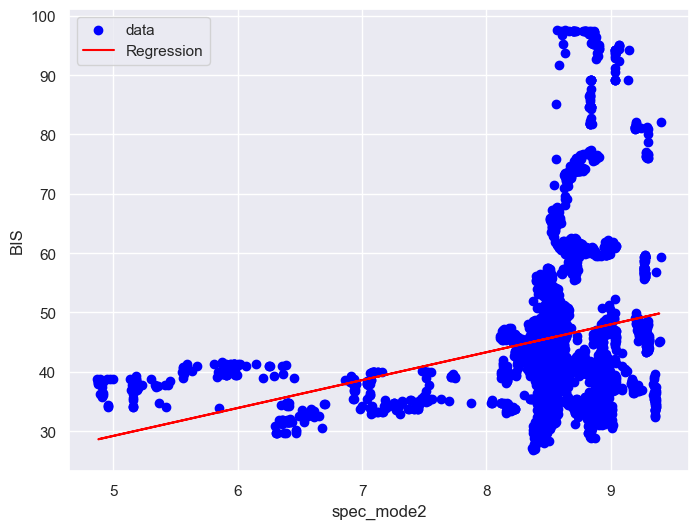

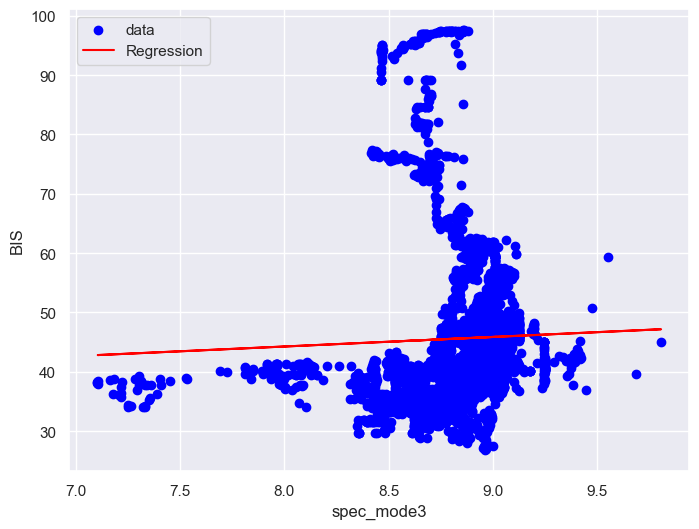

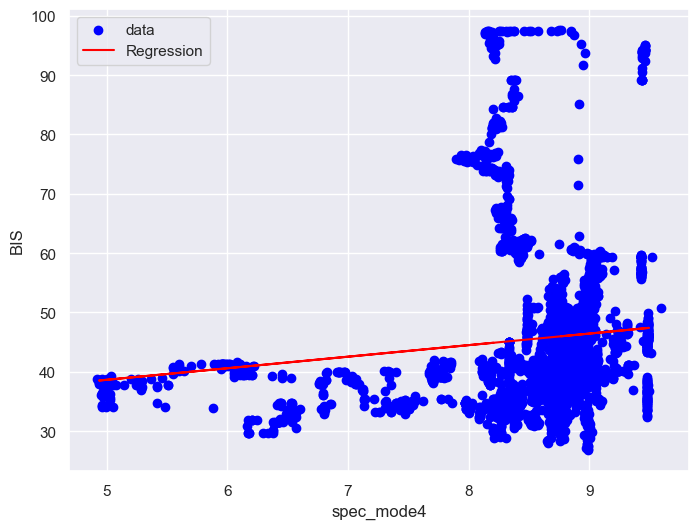

In [108]:
for column in df_spec.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_spec, column)

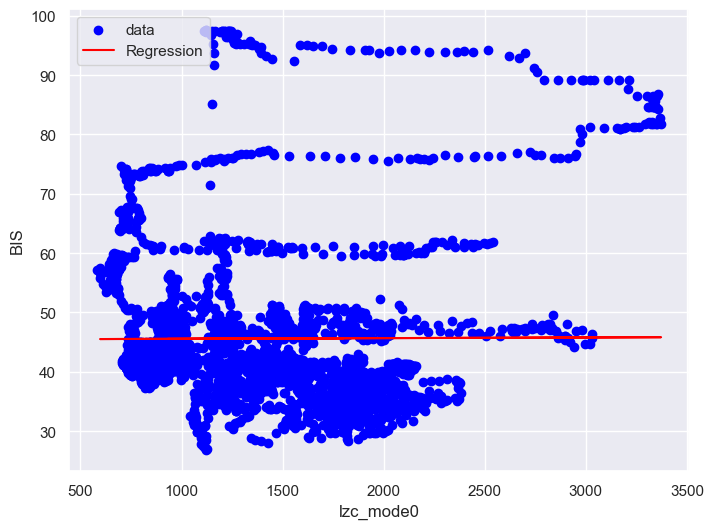

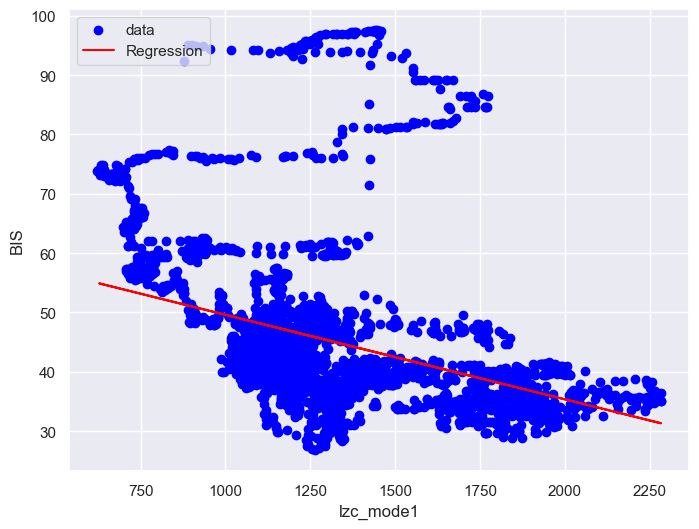

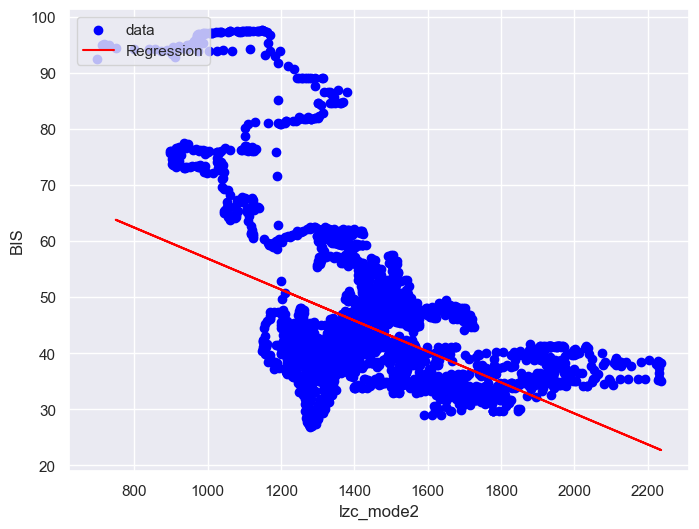

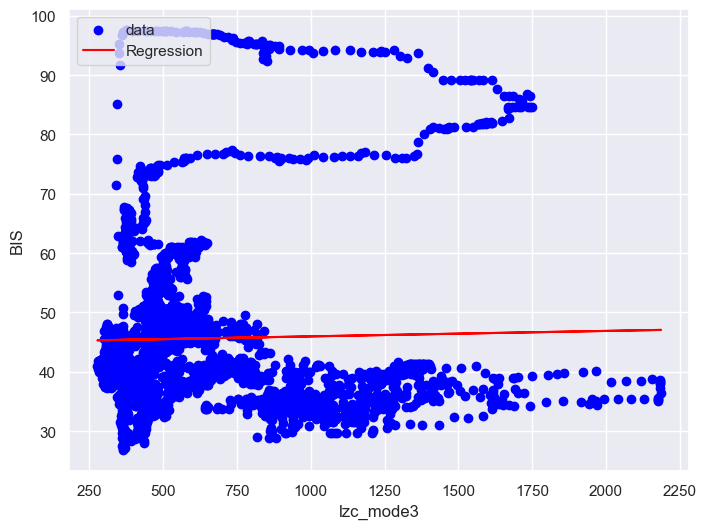

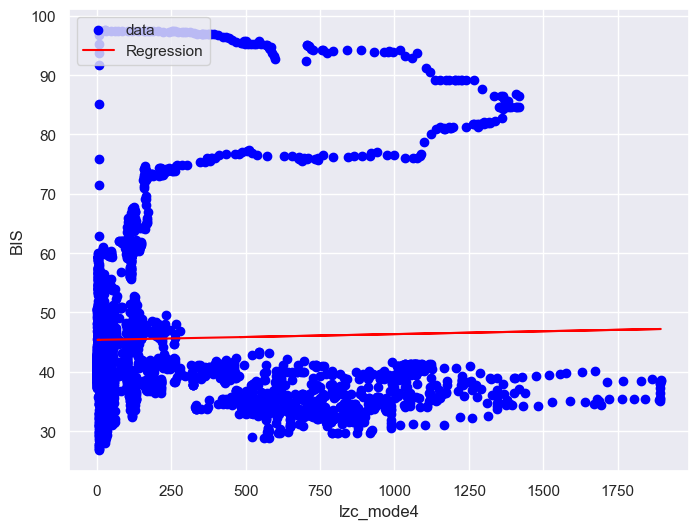

In [109]:
for column in df_lzc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_lzc, column)

In [110]:
# Metrics
total=pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})


In [111]:
sort_total=total.sort_values('Values', ascending=False)
sort_total

Metrics     Values
2       pet_mode2_r2  51.888859
17  Perment_mode2_r2  51.635280
37      lzc_mode2_r2  20.674655
1       pet_mode1_r2  17.944450
16  Perment_mode1_r2  17.783800
24     Disp_mode4_r2  14.561790
23     Disp_mode3_r2  12.440417
36      lzc_mode1_r2  11.673932
27      svd_mode2_r2   7.936305
20     Disp_mode0_r2   7.773784
30     spec_mode0_r2   7.010424
12       hm_mode2_r2   6.165311
32     spec_mode2_r2   5.662177
3       pet_mode3_r2   4.538396
18  Perment_mode3_r2   4.362227
7        hc_mode2_r2   4.032738
22     Disp_mode2_r2   3.710829
25      svd_mode0_r2   3.302859
28      svd_mode3_r2   2.896221
8        hc_mode3_r2   2.545746
13       hm_mode3_r2   2.248341
10       hm_mode0_r2   2.247870
6        hc_mode1_r2   1.630056
14       hm_mode4_r2   1.140405
19  Perment_mode4_r2   1.127904
29      svd_mode4_r2   0.973572
34     spec_mode4_r2   0.799722
0       pet_mode0_r2   0.569060
9        hc_mode4_r2   0.441034
5        hc_mode0_r2   0.280637
4       pet_mode4_r2   0.220232
33     spec_mode3_r2   0.187387
15  Perment_mode0_r2   0.137915
39      lzc_mode4_r2   0.121762
38      lzc_mode3_r2   0.114676
35      lzc_mode0_r2   0.030089
21     Disp_mode1_r2  -0.018494
31     spec_mode1_r2  -0.189345
26      svd_mode1_r2  -0.476696
11       hm_mode1_r2  -0.726100